# CAB420, Clustering, Example 3: How Many Clusters?
Dr Simon Denman (s.denman@qut.edu.au)

## Overview
Let's compare K-Means and a GMM, and look at what happens as we increase the number of clusters. To do this, we're going to use some real data. We'll use a segment of data that shows NY taxi usage. We'll only use one day's data to keep the example from being too slow, and we'll focus only on trips that end at JFK airport, again to reduce the data and make it easy to visualise.

## Too Long; Didn't Read:
* K-means and GMMs need us to specify a number of clusters. However specifying the number of clusters can require prior knowledge of the data, or other exploration.
* We can use a similar method to what we do for regression, and trade of complexity vs accuracy. More clusters will allows us to more accurately reconstruct the data, but at the cost or more parameters.
* We can use Bayesian Information Criterion (BIC) to determine the number of clusters with a GMM, and an approximation of this to determine the same for K-means.
* The BIC and it's approximation often returns quite large numbers of clusters, particularly for K-means. As such for K-means the elbow of the reconstruction curve is a well established heuristic to select the number of clusters. However we may also consider different number of clusters depending on our applications.

In [1]:
import pandas
import numpy
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from scipy.spatial import distance
import matplotlib.pyplot as plt

## PART 1: Load the data
We're using just a single day of data. Note that NY taxis come in two flavours:
* Green, which are trips that start outside of Manhattan
* Yellow, which are trips that start within Manhattan

We're going to grab both and combine them. Note that there are slight differences in the table format for the two sets of taxis. To work around this, we'll
* load the two sets
* pull out the columns that we want
* find trips that end at JFK airport
* and grab just those to cluster

In [2]:
green = pandas.read_csv('../data/NYTaxis/2016_Green_Taxi_Trip_Data.csv'); 
yellow = pandas.read_csv('../data/NYTaxis/2016_Yellow_Taxi_Trip_Data.csv');
green = green[['Lpep_dropoff_datetime', 'Dropoff_longitude', 'Dropoff_latitude']]
yellow = yellow[['tpep_pickup_datetime', 'dropoff_longitude', 'dropoff_latitude']]
green = green.rename(columns={'Lpep_dropoff_datetime':'time', 'Dropoff_longitude':'lon', 'Dropoff_latitude':'lat'})
yellow = yellow.rename(columns={'tpep_pickup_datetime':'time', 'dropoff_longitude':'lon', 'dropoff_latitude':'lat'})
taxis = pandas.concat([green, yellow])
print(taxis.shape)
taxis.head()

(409433, 3)


,time,lon,lat
0,01/01/2016 12:00:00 AM,-73.950668,40.811756
1,01/01/2016 12:00:00 AM,-73.999176,40.720001
2,01/01/2016 12:02:10 AM,-73.927147,40.708645
3,01/01/2016 12:40:56 AM,-73.984009,40.743137
4,01/01/2016 12:15:59 AM,-73.866203,40.920212


And then to make it easier to analyse, we'll just look at the dropoff locations around JFK airport.

In [3]:
taxis = taxis[(taxis['lon'] >= -73.805) & (taxis['lon'] <= -73.765) & (taxis['lat'] >= 40.636) & (taxis['lat'] <= 40.656)]
print(taxis.shape)
taxis.head()

(3205, 3)


,time,lon,lat
7219,01/01/2016 01:38:43 AM,-73.783577,40.644234
12536,01/01/2016 02:19:00 AM,-73.782440,40.644226
13253,01/01/2016 02:22:41 AM,-73.782433,40.644253
15727,01/01/2016 02:42:25 AM,-73.776321,40.645702
17101,01/01/2016 03:10:34 AM,-73.782715,40.644169


## PART 2: Clustering
One thing we haven't looked at yet is how many clusters we need. Let's start by getting some intial clustering results for K-means and GMMs with the data.

For each we'll look at 4, 8 and 12 clusters.

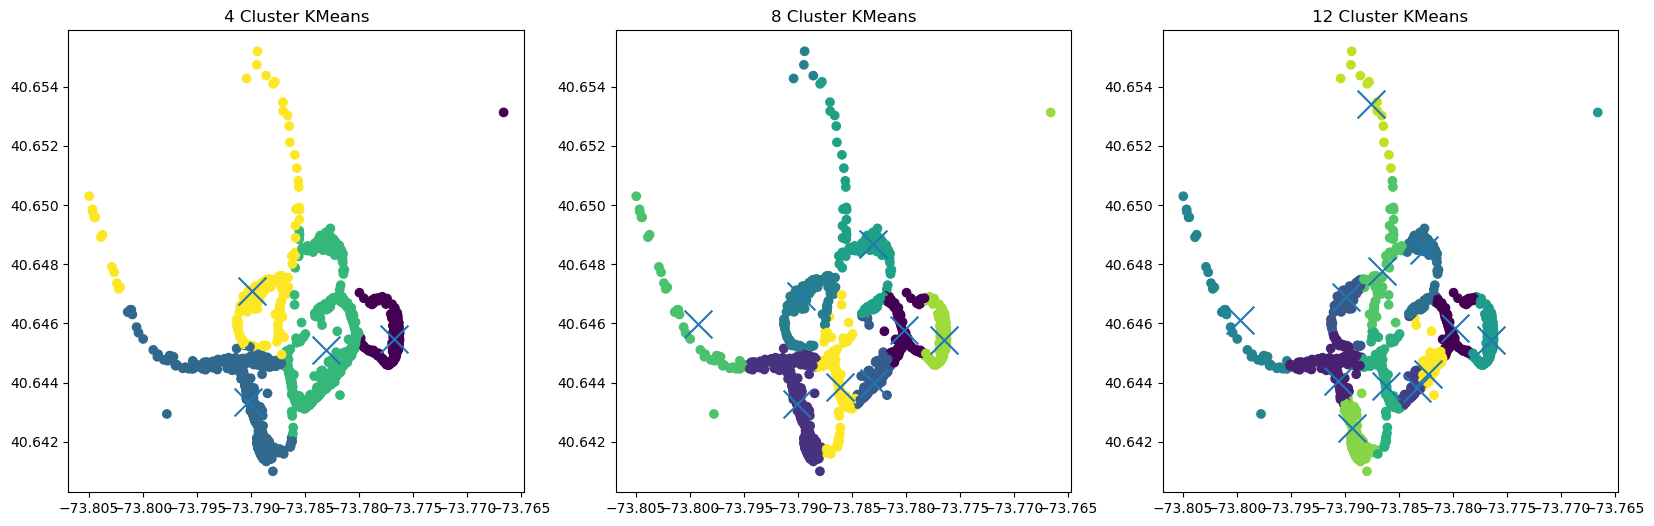

In [4]:
fig = plt.figure(figsize=[20, 6])
ax = fig.add_subplot(1, 3, 1)
kmeans = KMeans(n_clusters=4, random_state=4, n_init='auto').fit(taxis[['lon', 'lat']])
ax.scatter(taxis['lon'], taxis['lat'], c=kmeans.labels_);
ax.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], marker='x', s=400)
ax.set_title('4 Cluster KMeans')

kmeans = KMeans(n_clusters=8, random_state=4, n_init='auto').fit(taxis[['lon', 'lat']])
ax = fig.add_subplot(1, 3, 2)
ax.scatter(taxis['lon'], taxis['lat'], c=kmeans.labels_);
ax.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], marker='x', s=400)
ax.set_title('8 Cluster KMeans')

kmeans = KMeans(n_clusters=12, random_state=4, n_init='auto').fit(taxis[['lon', 'lat']])
ax = fig.add_subplot(1, 3, 3)
ax.scatter(taxis['lon'], taxis['lat'], c=kmeans.labels_);
ax.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], marker='x', s=400)
ax.set_title('12 Cluster KMeans');

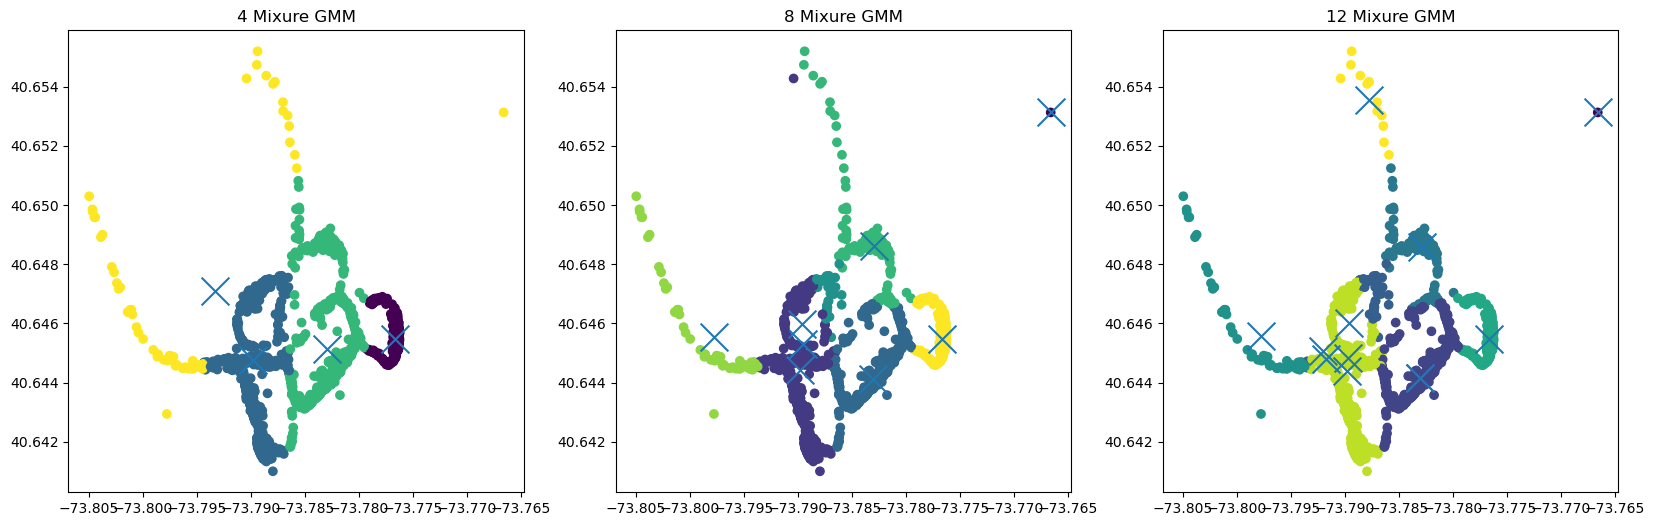

In [5]:
fig = plt.figure(figsize=[20, 6])

gmm = GaussianMixture(4, random_state=4)
gmm.fit(taxis[['lon', 'lat']])
labels = gmm.predict(taxis[['lon', 'lat']])
ax = fig.add_subplot(1, 3, 1)
ax.scatter(taxis['lon'], taxis['lat'], c=labels);
ax.scatter(gmm.means_[:,0], gmm.means_[:,1], marker='x', s=400)
ax.set_title('4 Mixure GMM')

gmm = GaussianMixture(8, random_state=4)
gmm.fit(taxis[['lon', 'lat']])
labels = gmm.predict(taxis[['lon', 'lat']])
ax = fig.add_subplot(1, 3, 2)
ax.scatter(taxis['lon'], taxis['lat'], c=labels);
ax.scatter(gmm.means_[:,0], gmm.means_[:,1], marker='x', s=400)
ax.set_title('8 Mixure GMM')

gmm = GaussianMixture(12, random_state=4)
gmm.fit(taxis[['lon', 'lat']])
labels = gmm.predict(taxis[['lon', 'lat']])
ax = fig.add_subplot(1, 3, 3)
ax.scatter(taxis['lon'], taxis['lat'], c=labels);
ax.scatter(gmm.means_[:,0], gmm.means_[:,1], marker='x', s=400)
ax.set_title('12 Mixure GMM');

We have clustering results. Which one wins? And why?

## Part 3: How Many Clusters?

We need a way to measure the error in the system. With K-means, our cost function is the average distance between the cluster assignment and the mean.

$C(\underline{x}, \underline{\mu}) = \sum_i ||x_i - \mu_{x_i}||^2$

We can measure and plot that. Let's do that for a bunch of values of K.

Thanks to the magic of sklearn, we can actually get this number from the inertia attribute which is:
> inertia_ :float
>
>   Sum of squared distances of samples to their closest cluster center.

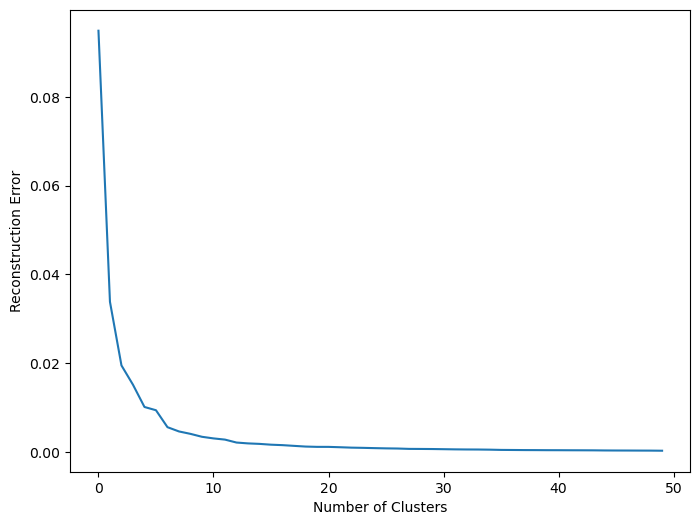

In [6]:
recon_error = []
for i in range (50):
    kmeans = KMeans(n_clusters=(i+1), random_state=4, n_init='auto').fit(taxis[['lon', 'lat']])
    recon_error.append(kmeans.inertia_)

fig = plt.figure(figsize=[8, 6])
ax = fig.add_subplot(1, 1, 1)
ax.plot(recon_error)
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Reconstruction Error');    

We can see our cost quickly drops and converges towards 0. The most clustes we add, the lower this will go. What we are measuring here is the distance between the cluster centres and those points assigned to them. As such, the more cluster cetntres we have, the lower this will go as we will keep creating smaller and smaller groups, each of one which is a bit more tightly packed, until we get to a point where we have as many clusters as points and each point is it's own cluster centre (at which point, we've also clustered absolutely nothing).

There is however a simple heuristic that we can use based on this. Often you will see people selecting the number of clusters based on the location of the "elbow" in the graph. In our case this is around 5-6 clusters. Prior to this point, we get a large drop for each extra cluster we add, where as after this point we see that gain start to drop, so it's effectivley not worth adding another cluster to the data. This is a fairly coarse heuristic, though it is very widely used as a way to determine the number of clusters.

### Information Criterions - A Better Way to Select the Number of Clusters
We can however add a penalty for model complexity to help overcome the limitations of the "elbow method", while keeping the spirit of this approach. This is based on the idea that we'd like to make our model more complex (i.e. add a mode) only if that mode leads to a substantial improvement. We can see from the above plot, we get a big reduction in error when adding clusters when K is small (i.e. the drop from k=1 to k=2), but when k becomes larger (i.e. k=15) the drop to the next value is quite small. We can modify our cost function as follows:

$I(\underline{x},\underline{\mu}) = m log [ \frac{1}{m} \sum_{i} || x_{i} - \mu_{x_{i}}||^2 ] + k log m$

Note that in our implementation below, we set k to the number of clusters times 3. This comes from the XMeans paper (http://www.aladdin.cs.cmu.edu/papers/pdfs/y2000/xmeans.pdf), in which they calculate the number of free variables for a k-means model with k centroids in d-dimentional space to be k*(d+1), i.e. 3.

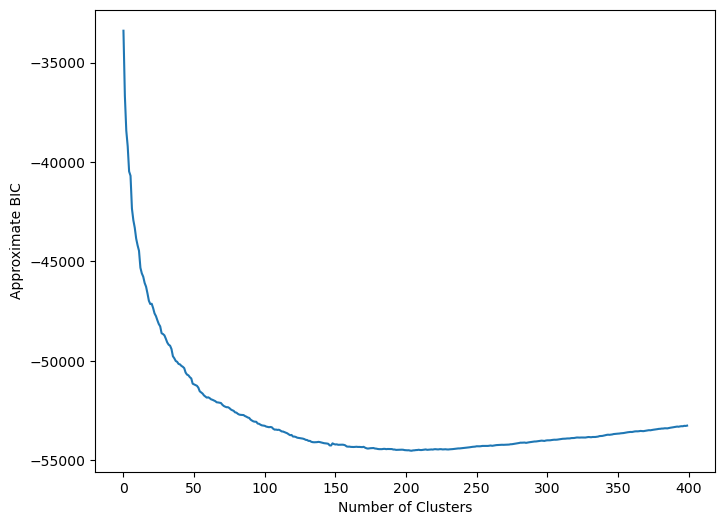

In [7]:
def compute_approximate_bic(kmeans,X):
    
    k = numpy.shape(kmeans.cluster_centers_)[0]*(numpy.shape(kmeans.cluster_centers_)[1] + 1)
    m = len(X)
    
    approx_bic = m*numpy.log(kmeans.inertia_ / m) + k*numpy.log(m)
    return approx_bic    

bic = []
for i in range (400):
    kmeans = KMeans(n_clusters=(i+1), random_state=4, n_init='auto').fit(taxis[['lon', 'lat']])
    bic.append(compute_approximate_bic(kmeans, numpy.array(taxis[['lon', 'lat']])))

fig = plt.figure(figsize=[8, 6])
ax = fig.add_subplot(1, 1, 1)
ax.plot(bic)
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Approximate BIC');  

What we see is that our BIC approximation bottoms out around 200. This is still a lot of clusters though, particularly given that we only have a bit over 3,000 data points. Depending on what we are trying to do, this may leave us with a number of clusters which does not suit our task. If for example we are trying to use k-means to cluster our data to help us simplify and visualise things, 200 clusters may still be too many.

Let's get back to GMMs now, where we can do something similar. 

What we have used above if an approximation of the Bayesian Information Criterion. With a GMM, we can use the actual BIC, and python will compute this for us

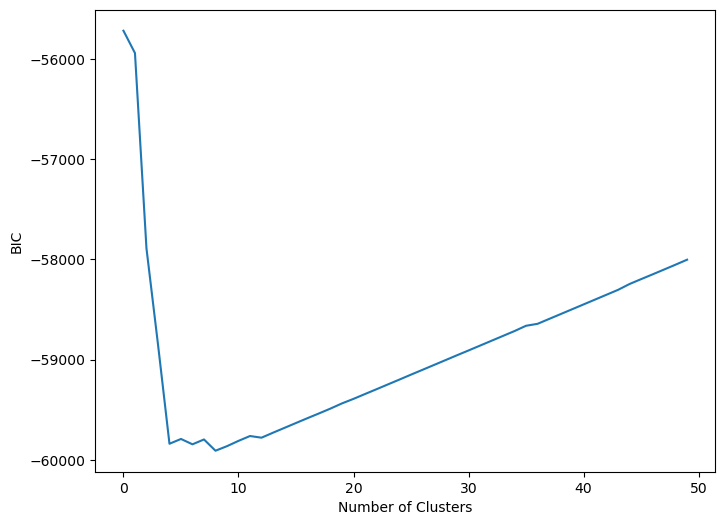

In [8]:
bics = []
for i in range (50):
    gmm = GaussianMixture(i+1, random_state=4)
    gmm.fit(taxis[['lon', 'lat']])
    bics.append(gmm.bic(taxis[['lon', 'lat']]))
    
fig = plt.figure(figsize=[8, 6])
ax = fig.add_subplot(1, 1, 1)
ax.plot(bics)
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('BIC');

We see this time that our model bottoms around 10, before the BIC starts to increase again. This is much smaller than we see with K-means, why? The GMM has more parameters, we now have not just a cluster centre (as for k-means), but also standard deviations and mixture weights. This means that the penalty for adding modes is biger.

However the GMM also tells us more about the data, we get information on how well a given point matches each component, so we capture uncertainty in decisions.